# Advanced Regression techniques

#DataAugmentation#nolinearmodeling#interactionModel

Hello Everyone! 
<br>
The link for this challenge is the following: https://www.kaggle.com/c/house-prices-advanced-regression-techniques


<b> Context

Use ML techniques to predict the price house
<br>
The challenge is to deal with a high number of categorical features

<b> Methodology

* K-fold cross validation
* parameter tunning
* final Prediction

<b> Result

Final test using Mean Logaritmic Square Error and some remarks

### General Libraries

In [27]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta  

import scipy as sp
import random
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge, Lasso , LinearRegression, RANSACRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from ARTfuncs import dict_to_replace,dict_to_replace_2, additional_numerical, additional_categorical, replacer_categorical, replacer_categorical_2 
from ARTfuncs import convert_categoricals, control_outlier_numerical, convert_TotalBsmtSF, split_category_in_categorical, years_vars_and_extra_numericasl, mask_feature,feature_transformation_1

In [6]:
from ARTfuncs import scaler, prep_interactin_terms, prob, try_augmentation, traindata_totrain, inverse_scaling, columniser, dataframe_to_plot,correct_extreme_values, gets_metrics
from ARTfuncs import selected_interaction_terms, selected_categorical_features, selected_numerical_features, selected_categorical_dummies_features

## Processing

the submission contains the forecasted prices, then I merge the submission and the Test set

In [7]:
train = pd.read_csv(r'C:\Users\Miguel\kaggle\ART\train.csv')
ss = pd.read_csv(r'C:\Users\Miguel\kaggle\ART\sample_submission.csv')
test = pd.read_csv(r'C:\Users\Miguel\kaggle\ART\test.csv')
test = test.merge(ss, left_on = 'Id', right_on = 'Id', how = 'inner')

In [8]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Preparing algorithm

In [9]:
interaction_df = pd.read_csv('Interaction Terms.csv').drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'])

In [10]:
def prepare_data_model_train_validation(data, randomseed = False, intercept_vector = False, augmentation = False, n_augmentation = False):
    ### spliting the data
    if randomseed == True:
        seed = random.randint(100, 1000)
    else:
        seed = randomseed
    validation_dataset = data.sample(frac = 0.25, replace = False, random_state = seed)
    validation_dataset = validation_dataset.copy()
    train_dataset = train[~train.index.isin(validation_dataset.index)]

    train_dataset = feature_transformation_1(train_dataset, dict_to_replace, additional_numerical, replacer_categorical, replacer_categorical_2, additional_numerical,[])
    train_dataset = columniser(train_dataset,'SalePrice',selected_numerical_features, selected_categorical_features)

    ## Feature Preparation
    scaled_train_dataset, scalerx, num_columns_head, cat_columns_head, interaction_terms_list = prep_interactin_terms(dataset = train_dataset,
                                                        WholeCategoricals = selected_categorical_features,
                                                        WholeNumericals = selected_numerical_features, SelectedDummies = selected_categorical_dummies_features,
                                                        dataReferencial = interaction_df , scale =  True)
    ## Augmentation
    if randomseed == True:
        seed2 = random.randint(100, 1000)
    else:
        seed2 = randomseed
        
    augmented_data_train = try_augmentation(scaled_train_dataset, 'SalePrice', num_columns_head, cat_columns_head, seed2, n_augmentation)
    train_dataset_touse = traindata_totrain(scaled_train_dataset, augmented_data_train, augment = augmentation)
    train_dataset_touse = train_dataset_touse.copy()

    ## X and Y
    X__train = train_dataset_touse.iloc[:,0:-1]
    Y_train = train_dataset_touse.iloc[:,-1]
    X__train_reten = X__train.assign(intercept = 1) 

    ## Preparing validation data
    validation_dataset_prep = feature_transformation_1(validation_dataset, dict_to_replace, additional_numerical, replacer_categorical, replacer_categorical_2, additional_numerical,[])
    validation_dataset_prep = columniser(validation_dataset_prep,'SalePrice',selected_numerical_features, selected_categorical_features)

    scaled_validation_dataset = prep_interactin_terms(dataset = validation_dataset_prep,
                          WholeCategoricals = selected_categorical_features,
                          WholeNumericals = selected_numerical_features, SelectedDummies = selected_categorical_dummies_features,
                          dataReferencial = interaction_df,
                          scale =  False, scalers_exist = scalerx,
                          base_columns = (num_columns_head, cat_columns_head))

    X__validation = scaled_validation_dataset.iloc[:,0:-1]
    Y_validation = scaled_validation_dataset.iloc[:,-1]
    X__validation_reten = X__validation.assign(intercept = 1) ### artificial intercept
    
    heads = {'categorical': cat_columns_head, 'numerical':num_columns_head}
    
    if intercept_vector:
        return X__train, Y_train, X__train_reten, X__validation, Y_validation, X__validation_reten, scalerx, heads
    else:
        return X__train, Y_train, X__validation, Y_validation, scalerx, heads

In [11]:
def prediction_validation(model, X__validation, Y_validation, art_intercept = False, X__validation_reten = None, header = None ):
    ## prediction
    if art_intercept:
        Y_validation_pred = model.predict(X__validation_reten)
    else:
        Y_validation_pred = model.predict(X__validation)
        
    num_columns_head, cat_columns_head = header['numerical'], header['categorical']
        
    validation_inversed_scaled_data = inverse_scaling(X__validation, Y_validation, scalerx, num_columns_head, cat_columns_head)
    validationpred_inversed_scaled_data = inverse_scaling(X__validation, Y_validation_pred, scalerx, num_columns_head, cat_columns_head)

    df_plot = dataframe_to_plot(validation_inversed_scaled_data, validationpred_inversed_scaled_data)
    df_plot['y_pred'] = correct_extreme_values(df_plot['y_pred'])
    df_plot['error'] = df_plot['SalePrice'] - df_plot['y_pred']

    ransag_val_metrcs = gets_metrics(df_plot,'Val')
    
    return ransag_val_metrcs

### Hyper Parameter Tunning with cross validation: Lasso

In [12]:
def plot_results(results):
    list_dfs = list()
    for i in range(len(results)):
        data = {'MAE':list(results[i].values())[0][1],  'MSLE':list(results[i].values())[0][0]}
        df = pd.DataFrame(data)
        df['alpha'] = list(results[i].keys())[0]
        df['alpha_order'] = 'alpha'+str(i + 1)
        list_dfs.append(df)
    df_result = pd.concat(list_dfs)
    df_result = pd.melt(df_result, id_vars=['alpha','alpha_order'], value_vars=['MAE','MSLE'], var_name='metric', value_name='value')
    df_result['mean_value'] = df_result.groupby(['alpha_order','metric']).value.transform(np.mean)
    
    fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(23,12))

    sns.violinplot(ax = axs[0] , data = df_result[df_result.metric == 'MSLE'].sort_values('mean_value') , x="alpha_order", y="value")
    sns.violinplot(ax = axs[1] , data = df_result[df_result.metric == 'MAE'].sort_values('mean_value') , x="alpha_order", y="value")
    
    axs[0].set_title('Distribution MSLE', fontsize=12)
    axs[1].set_title('Distribution MAE', fontsize=12)
    
    fig.show()
    return df_result

In [48]:
n_alphas = 20
alphas = np.logspace(-5, -0.0001, n_alphas)
repetitions = 10
results_lasso = list()

for alpha in alphas:
    MSLE_lasso, MAE_lasso = list(), list()
    for _ in range(repetitions):
        X__train, Y_train, X__validation, Y_validation, scalerx, headers = prepare_data_model_train_validation(train, randomseed = True,
                                            intercept_vector = False, augmentation = True, n_augmentation = 550)
        ## Training model
        linearModel = Lasso(alpha=alpha, fit_intercept=True)
        linearModel.fit(X__train, Y_train)

        result_validation = prediction_validation(linearModel,X__validation,Y_validation, False, None, headers )

        MSLE_lasso.append(result_validation['Val']['MSLE'])
        MAE_lasso.append(result_validation['Val']['MAE'])
        
    dicst_result = {alpha:[MSLE_lasso, MAE_lasso]}
    results_lasso.append(dicst_result)

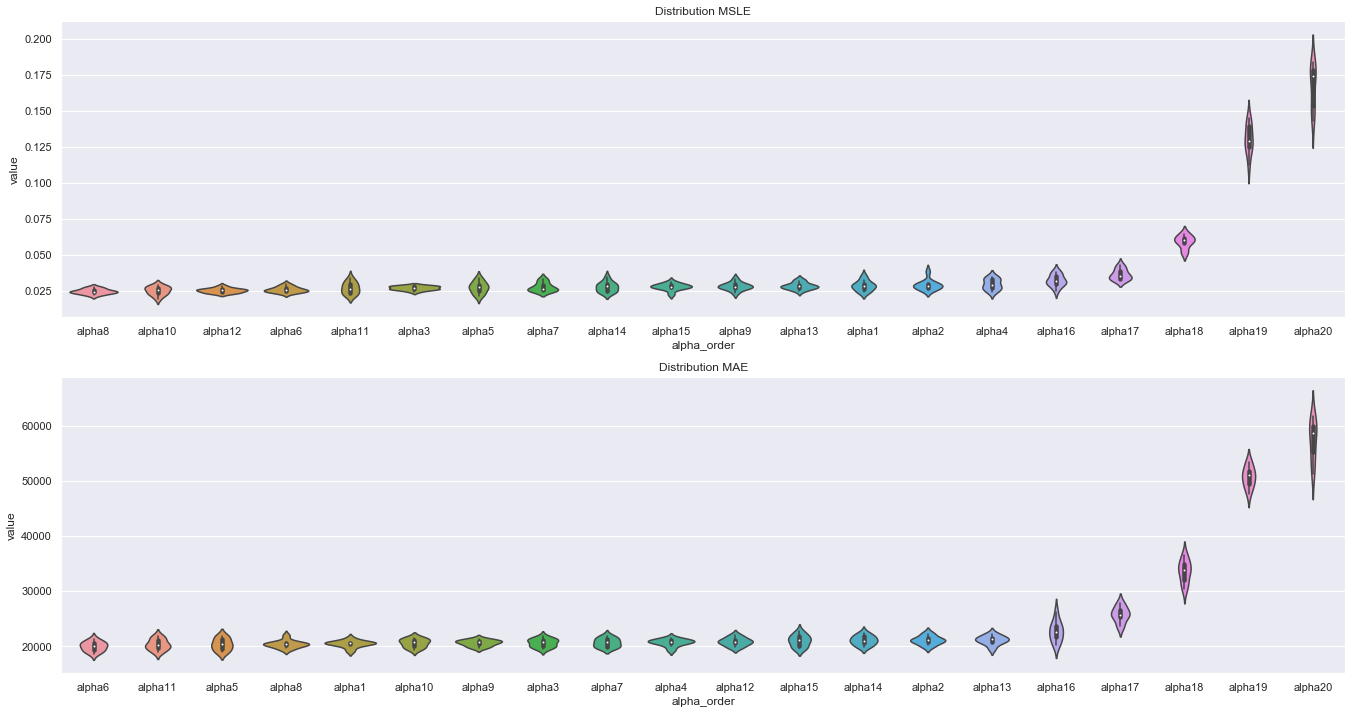

In [49]:
lasso_results = plot_results(results_lasso)

In [50]:
label = f'alpha{16}'
alpha = lasso_results[ (lasso_results.alpha_order == label)  ].alpha.unique()[0] 
MSLE = lasso_results[ (lasso_results.alpha_order == label) & (lasso_results.metric == 'MSLE') ].mean_value.unique()
MAE = lasso_results[ (lasso_results.alpha_order == label) & (lasso_results.metric == 'MAE') ].mean_value.unique()
print(f'the alpha is: {alpha} with mean MSLE:{MSLE} and MAE:{MAE}')

the alpha is: 0.08857057694933844 with mean MSLE:[0.03240333] and MAE:[22756.55306693]


### Hyper Parameter Tunning with cross validation: Ridge

In [51]:
n_alphas = 20
alphas = np.logspace(-3.5, -0.0001, n_alphas)
repetitions = 10
results_ridge = list()

for alpha in alphas:
    MSLE_ridge, MAE_ridge = list(), list()
    for _ in range(repetitions):
        X__train, Y_train, X__validation, Y_validation, scalerx, headers = prepare_data_model_train_validation(train, randomseed = True,
                                            intercept_vector = False, augmentation = True, n_augmentation = 550)
        ## Training model
        linearModel = Ridge(alpha=alpha, fit_intercept=True)
        linearModel.fit(X__train, Y_train)

        result_validation = prediction_validation(linearModel,X__validation,Y_validation, False, None, headers )

        MSLE_ridge.append(result_validation['Val']['MSLE'])
        MAE_ridge.append(result_validation['Val']['MAE'])
        
    dicst_result = {alpha:[MSLE_ridge, MAE_ridge]}
    results_ridge.append(dicst_result)

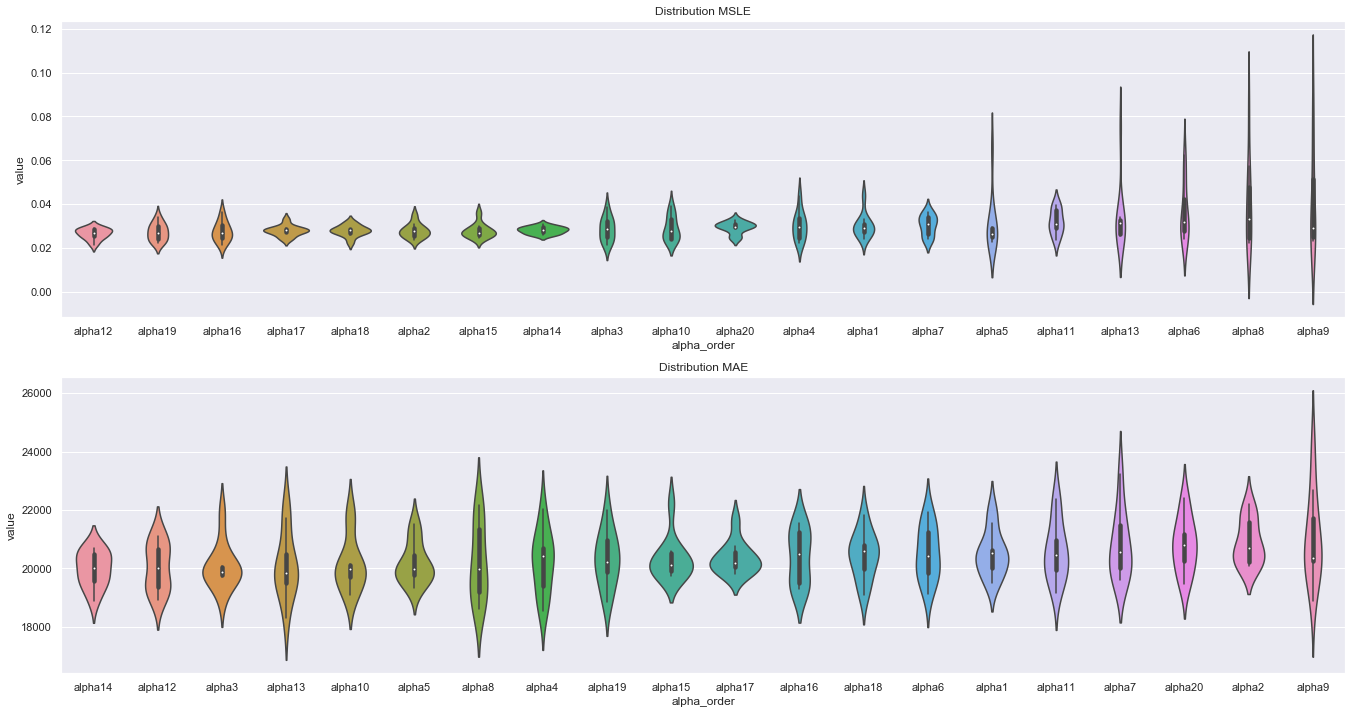

In [52]:
ridge_results = plot_results(results_ridge)

In [53]:
label = f'alpha{11}'
alpha = lasso_results[ (ridge_results.alpha_order == label)  ].alpha.unique()[0] 
MSLE = lasso_results[ (ridge_results.alpha_order == label) & (ridge_results.metric == 'MSLE') ].mean_value.unique()
MAE = lasso_results[ (ridge_results.alpha_order == label) & (ridge_results.metric == 'MAE') ].mean_value.unique()
print(f'the alpha is: {alpha} with mean MSLE:{MSLE} and MAE:{MAE}')

the alpha is: 0.00428081358109642 with mean MSLE:[0.02716904] and MAE:[20363.37090115]


### K fold cross_validation

In [54]:
def k_fold_crossvalidation(machine,model_name, repetitions, intercept_vector = False):
    MAE_results = list()
    MSLE_results = list()
    model_name_list = list()
    for _ in range(repetitions):
        if intercept_vector == True:
            X__train, Y_train, X__train_reten, X__validation, Y_validation, X__validation_reten, scalerx, headers = prepare_data_model_train_validation(train, randomseed = True,
                                                intercept_vector = True, augmentation = True, n_augmentation = 550)
        ## Training model
            machine.fit(X__train_reten, Y_train)
            result_validation = prediction_validation(machine, X__validation, Y_validation, True, X__validation_reten, headers )
            
        elif intercept_vector == False:
            X__train, Y_train, X__validation, Y_validation, scalerx, headers = prepare_data_model_train_validation(train, randomseed = True,
                                            intercept_vector = False, augmentation = True, n_augmentation = 550)
            machine.fit(X__train, Y_train)
            result_validation = prediction_validation(linearModel,X__validation,Y_validation, False, None, headers )

        MSLE_results.append(result_validation['Val']['MSLE'])
        MAE_results.append(result_validation['Val']['MAE'])
        model_name_list.append(model_name)
    
    dict_data = {'Model': model_name_list, 'MSLE': MSLE_results, 'MAE': MAE_results}
    result_df = pd.DataFrame(dict_data)
    return result_df

In [55]:
linearModelRanSac = RANSACRegressor(max_trials = 240, random_state = 95, loss = 'squared_loss',max_skips = 85)
ransag_result = k_fold_crossvalidation(linearModelRanSac, 'Ransag', repetitions = 20, intercept_vector = True)

In [56]:
alpha = 0.0014382755749939708
ridge_regression = linearModel = Ridge(alpha=alpha, fit_intercept=True)
ridge_result = k_fold_crossvalidation(ridge_regression, 'Ridge', repetitions = 20, intercept_vector = False)

In [57]:
alpha = 0.08857057694933844
lasso_regression = linearModel = Ridge(alpha=alpha, fit_intercept=True)
lasso_result = k_fold_crossvalidation(lasso_regression, 'Lasso', repetitions = 20, intercept_vector = False)

In [58]:
consolidated_result = pd.concat([ransag_result,ridge_result,lasso_result])

Text(0.5, 1.0, 'Distribution MAE')

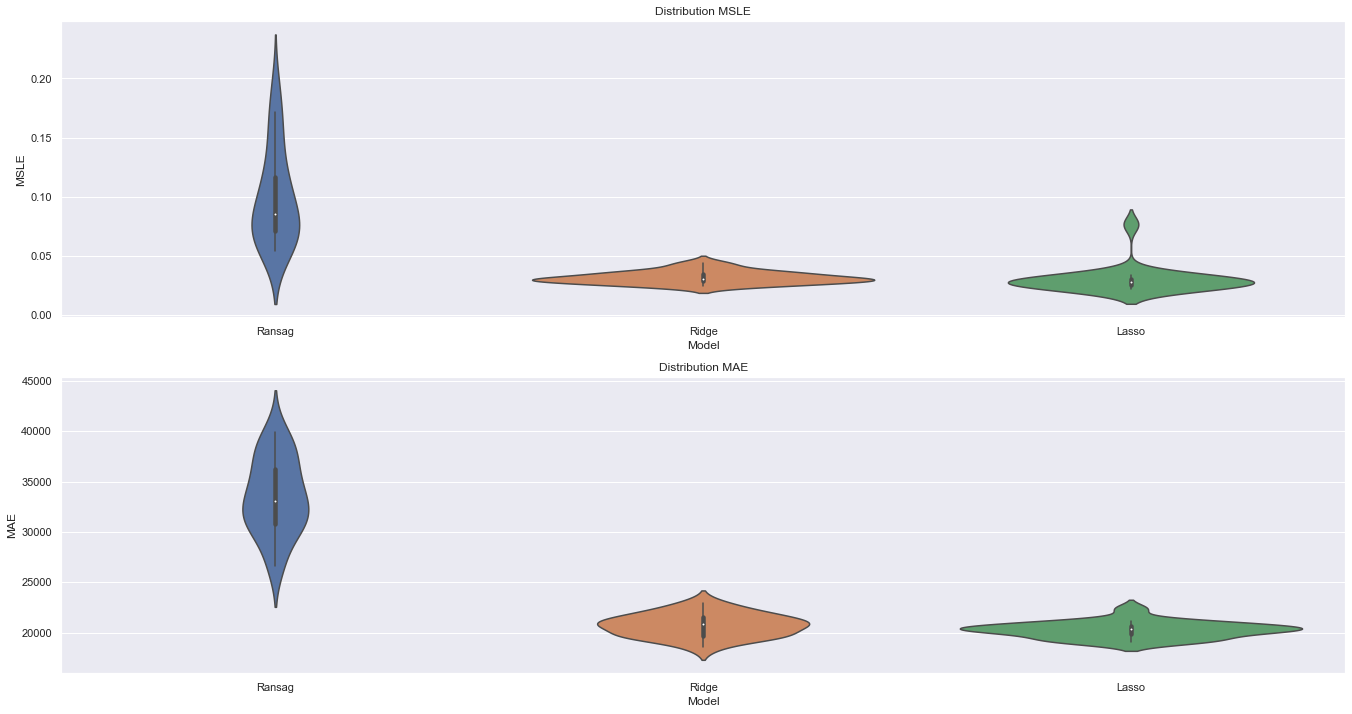

In [59]:
consolidated_result

fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(23,12))

sns.violinplot(ax = axs[0] , data = consolidated_result, x="Model", y="MSLE")
sns.violinplot(ax = axs[1] , data = consolidated_result, x="Model", y="MAE")
    
axs[0].set_title('Distribution MSLE', fontsize=12)
axs[1].set_title('Distribution MAE', fontsize=12)

### Final Prediction

In [28]:
alpha = 0.08857057694933844
ridge_regression = linearModel = Lasso(alpha=alpha, fit_intercept=True)

In [29]:
X__train, Y_train, _, _, scalerx, headers = prepare_data_model_train_validation(train, randomseed = True,
                                            intercept_vector = False, augmentation = True, n_augmentation = 550)

ridge_regression.fit(X__train, Y_train)

Lasso(alpha=0.08857057694933844, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [30]:
test_dataset = feature_transformation_1(test.fillna(0), dict_to_replace, additional_numerical, replacer_categorical, replacer_categorical_2, additional_numerical,[])
test_dataset = columniser(test_dataset,'SalePrice',selected_numerical_features, selected_categorical_features)

In [31]:
num_columns_head, cat_columns_head = headers['numerical'], headers['categorical']
scaled_test_dataset = prep_interactin_terms(dataset = test_dataset,
                      WholeCategoricals = selected_categorical_features,
                      WholeNumericals = selected_numerical_features, SelectedDummies = selected_categorical_dummies_features,
                      dataReferencial = interaction_df,
                      scale =  False, scalers_exist = scalerx,
                      base_columns = (num_columns_head, cat_columns_head))

In [32]:
X__test = scaled_test_dataset.iloc[:,0:-1]
Y_test = scaled_test_dataset.iloc[:,-1]
Y_test_pred = linearModel.predict(X__test)
Y_test_pred = correct_extreme_values(Y_test_pred)

In [33]:
test_inversed_scaled_data = inverse_scaling(X__test, Y_test, scalerx, num_columns_head, cat_columns_head)
testpred_inversed_scaled_data = inverse_scaling(X__test, Y_test_pred, scalerx, num_columns_head, cat_columns_head)

In [34]:
dictdata = {'Id':test['Id'],'SalePrice':testpred_inversed_scaled_data['SalePrice']}
pd.DataFrame(dictdata).to_csv('Predictions_v6.csv',index=False)